QRS peak detection using pan tomking algorithm and displaying on the four stages of the algorithm.

In [ ]:
Displaying Raw data

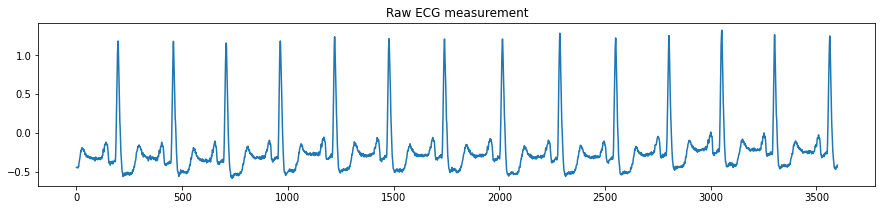

In [2]:

# Demo 1 - Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Radhiana Idowa  - Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import neurokit2 as nk
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 3]
sig, fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/105',sampfrom=0, sampto=3600) 
unfiltered_signal = sig[:, 0]
plt.title("Raw ECG measurement")
plt.plot(unfiltered_signal)
plt.show()

Band bass filter

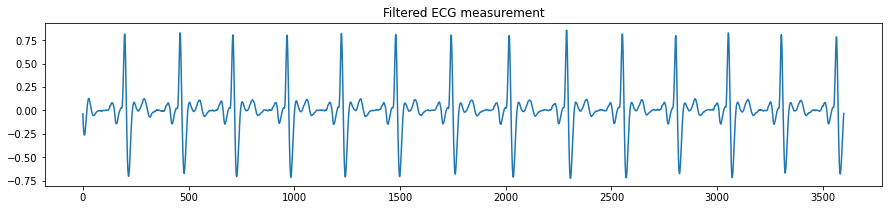

In [3]:

fs = 360
f1 = 5/fs
f2 = 15/fs
b, a = signal.butter(1, [f1*2, f2*2], btype='bandpass')
filtered_ecg = signal.lfilter(b, a, unfiltered_signal)
plt.plot(filtered_ecg)
plt.title("Filtered ECG measurement")
plt.show()

Derivation (differentiation)

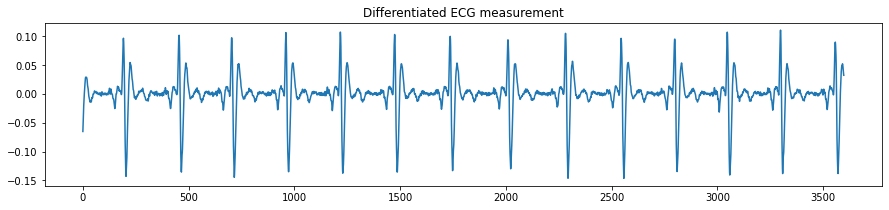

In [4]:
# Derivation (differentiation
diff = np.diff(filtered_ecg) 
plt.plot(diff)
plt.title("Differentiated ECG measurement")
plt.show()

Squaring

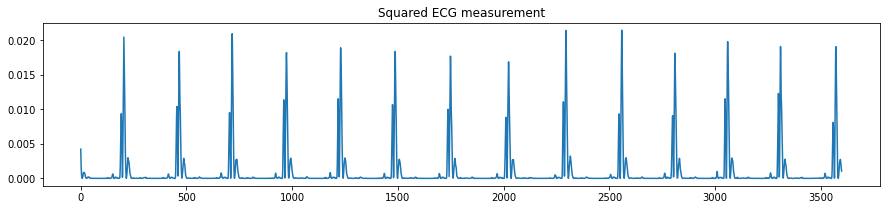

In [5]:
# Squared
squared = diff*diff
plt.plot(squared)
plt.title("Squared ECG measurement")
plt.show()

Peak detection

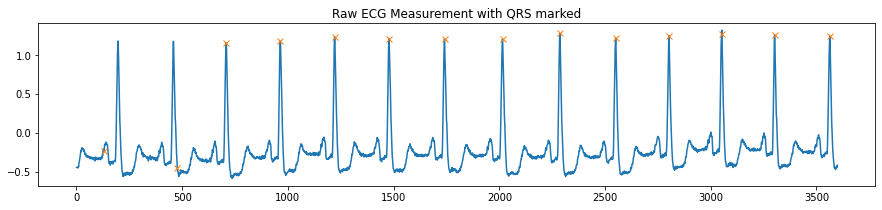

In [6]:
# Peak detection
from test import panPeakDetect, MWA_from_name
N = int(0.12*fs)
mwa = MWA_from_name("cumulative")(squared, N)
mwa[:int(0.2*fs)] = 0
mwa_peaks = panPeakDetect(mwa, fs)
plt.figure(figsize=(15,3))
plt.plot(unfiltered_signal)
plt.plot(mwa_peaks, unfiltered_signal[mwa_peaks], "x")
plt.title("Raw ECG Measurement with QRS marked")
plt.show()

Extraction of data point

In [7]:
sig, fields = wfdb.rdsamp('mit-bih-arrhythmia-database-1.0.0/100', channels=[0])
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


In [8]:
# Calculate pre rr interval
from wfdb import processing
pre_rr_interval = processing.calc_rr(xqrs.qrs_inds,fs=360)
print(pre_rr_interval)


[294 292 284 ... 253 249 259]


In [9]:
# Calculate post rr interval
from scipy.ndimage.interpolation import shift
post_rr_interval = shift(pre_rr_interval, -1, cval=np.NaN)
print(post_rr_interval)

[                 292                  284                  285 ...
                  249                  259 -9223372036854775808]


In [10]:
# Mean value of RR intervals
rr_mean = np.ones(len(pre_rr_interval)) * pre_rr_interval.mean()
print(rr_mean)

[286.05457746 286.05457746 286.05457746 ... 286.05457746 286.05457746
 286.05457746]


In [23]:

_, waves_peak = nk.ecg_delineate(sig[:,0], {"ECG_R_Peaks": xqrs.qrs_inds}, sampling_rate=360, method="dwt")

In [58]:
# Boolean value indicating the presence of P wave
p_peaks = waves_peak["ECG_P_Peaks"]
df = pd.DataFrame(p_peaks)
p_wave_presence = df.applymap(lambda x: 1 if x else  0)
p_wave_presence = p_wave_presence.to_numpy()
p_wave_presence = p_wave_presence.reshape(1,-1)[0]
print(p_wave_presence)

[1 1 1 ... 1 1 1]


In [39]:
# QRS complex duration
q_onsets = np.array(waves_peak["ECG_R_Onsets"])
q_offsets = np.array(waves_peak["ECG_R_Offsets"])
q_duration = q_offsets - q_onsets
q_duration_df = pd.DataFrame(q_duration)

         0
0      NaN
1     37.0
2     33.0
3     36.0
4     33.0
...    ...
2268  34.0
2269  34.0
2270  34.0
2271  33.0
2272   NaN

[2273 rows x 1 columns]


In [46]:
# Duration of ST interval
q_offsets = np.array(waves_peak["ECG_R_Offsets"]) 
t_offsets = np.array(waves_peak["ECG_T_Offsets"])  
st_interval  = t_offsets - q_offsets
df_st_interval = pd.DataFrame(st_interval)
print(df_st_interval)

          0
0     136.0
1      81.0
2      75.0
3     137.0
4      23.0
...     ...
2268   23.0
2269  115.0
2270   39.0
2271  113.0
2272    NaN

[2273 rows x 1 columns]


In [59]:
# Dataset on a matrix
dataset = pd.DataFrame(np.array([pre_rr_interval,post_rr_interval,rr_mean,st_interval,q_duration,p_wave_presence]))
dataset

,0
0,"[294, 292, 284, 285, 284, 294, 235, 358, 303, ..."
1,"[292, 284, 285, 284, 294, 235, 358, 303, 292, ..."
2,"[286.05457746478874, 286.05457746478874, 286.0..."
3,"[136.0, 81.0, 75.0, 137.0, 23.0, 146.0, 49.0, ..."
4,"[nan, 37.0, 33.0, 36.0, 33.0, 34.0, 34.0, 33.0..."
5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
